In [1]:
import cv2
import numpy as np
from scipy.stats import kurtosis,skew
import os
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
net = cv2.dnn.readNet('yolov4.weights', 'yolov4.cfg')

In [3]:
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [4]:
def get_flow_patches(flow,boxes,idx):
    #Extract a patch in the image corresponding to the object's bounding box in the frame.
    flows=[]
    if len(idx)>0:
        for i in idx.flatten():
            center_x,center_y,w,h=boxes[i]
            # Using the center x, y coordinates to derive the top
            # and the left corner of the bounding box
            x=int(center_x-(w/2))
            y=int(center_y-(h/2))
            ##
            #The following is done to deal with typical situation when x or y are going out of frame
            #i.e not whole bounding box in the frame
            
            #stores part of the width to be cropped which is out of frame
            subx=0
            #stores part of the height to be cropped which is out of frame
            suby=0
            
            if x<0 or x>=flow.shape[1]:
                subx=x if x<0 else -1*x
                x=0 if x<0 else flow.shape[1]-1
            if y<0 or y>=flow.shape[0]:
                suby=y if y<0 else -1*y
                y=0 if y<0 else flow.shape[0]-1
            ##
            flows.append(flow[y:y+int(h)+suby,x:x+int(w)+subx,:])
    return flows

In [5]:
import numpy.matlib
def knndis(t,M2):
    Mg=M2.shape[0]
    dist=np.sqrt(np.sum((np.matlib.repmat(t,Mg,1) - M2)**2,1))
    np.sort(dist)
    return sum(dist[0:10])/10

In [6]:
%store -r M2

In [7]:
%store -r Base_lm

In [8]:
%store -r threshold

In [9]:
%store -r g_min
%store -r g_max

In [10]:
print(Base_lm," ",threshold)

0.6133601705838747   1.4908750268820512


In [11]:
def frames_process(frames_path,AV2):
    St=[0]
    num=0
    frame_prev=None
    fine_tune=False
    count=0
    for img in np.sort(os.listdir(frames_path)):
        if img.endswith(".jpg"):
            image_path=os.path.join(frames_path,img)
            if frame_prev is None:
                frame_prev=cv2.imread(image_path)
                continue
            frame=cv2.imread(image_path)
            (height, width, _) = frame.shape
            prvs=cv2.cvtColor(frame_prev,cv2.COLOR_BGR2GRAY)
            curr=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            flow=cv2.calcOpticalFlowFarneback(prvs, curr, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            blob = cv2.dnn.blobFromImage(frame,1 / 255,(416, 416),(0, 0, 0),swapRB=True,crop=False)
            net.setInput(blob)
            output_layer_names = net.getUnconnectedOutLayersNames()
            layerOutputs = net.forward(output_layer_names)
            boxes = []
            confidences = []
            appearance = []
            for output in layerOutputs:
                for detection in output:
                    scores = detection[5:]
                    class_id = np.argmax(scores)
                    confidence = scores[class_id]
                    if confidence > 0.4:
                        center_x = detection[0] * width
                        center_y = detection[1] * height
                        w = detection[2] * width
                        h = detection[3] * height
                        boxes.append([center_x, center_y, w, h])
                        confidences.append(float(confidence))
                        appearance.append(scores)
            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.6, 0.4)
            i = 0
            t=list()
            if boxes != []:
                flows=get_flow_patches(flow,boxes,indexes)
                if flows!=[]:
                    for flow_patch in flows:
                        mag, _ = cv2.cartToPolar(flow_patch[..., 0], flow_patch[..., 1])
                        mean=np.mean(mag)
                        variance=np.var(mag)
                        kurtosis_=kurtosis(mag,None)
                        skew_=skew(mag,None)
                        cx,cy,wi,hi=boxes[indexes.flatten()[i]]
                        feature_matrix=np.array([mean,variance,kurtosis_,skew_]+[0.4*cx,0.4*cy,0.4*wi*hi]+list(0.9*appearance[indexes.flatten()[i]]))
                        for j in range(0,87):
                            #normalization applied to all features where it is valid
                            if g_min[j]!=g_max[j]:
                                feature_matrix[j]=(feature_matrix[j]-g_min[j])/(g_max[j]-g_min[j])
                        t.append(knndis(feature_matrix,M2))
                        i=i+1
            d=(np.max(t)-Base_lm)
            St.append(np.max((0,St[num]+d)))
            if fine_tune==True and num > 5:
                if St[num+1] - St[num] <=0:
                    if St[num] - St[num-1] <=0:
                        if St[num-1] - St[num-2] <=0:
                            St[num+1] = 0
                            fine_tune=False
            if(St[num+1]>threshold):
                fine_tune=True
            #print(St[num+1])
            '''if fine_tune==True:
                if(np.max((0,St[num]+d))>St[num]):
                    St.append(np.max((0,St[num]+d)))
                else:
                    
            else:
                fine_tune=False
                count=0
                St.append(np.max(0,d))
            
            if St[num+1]>threshold:
                fine_tune=True
            
            print(St[num+1])'''
            frame_prev = frame
            num=num+1
    #idx=np.where(np.array(vid)>threshold)
    cv2.destroyAllWindows()
    plt.plot(St/np.max(St))
    plt.show()
    AV2.append(St/np.max(St))

In [12]:
def load_image(imfile, device):
    img = np.array(Image.fromarray(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(device)


def viz(img1, img2, flo):
    img1 = img1[0].permute(1,2,0).cpu().numpy()
    img2 = img2[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    ax1.set_title('input image1')
    ax1.imshow(img1.astype(int))
    ax2.set_title('input image2')
    ax2.imshow(img2.astype(int))
    ax3.set_title('estimated optical flow')
    ax3.imshow(flo)
    plt.show()

In [13]:
def flow_res(file1,file2):
    #n_vis = 4
    
    image1 = load_image(file1, device)
    image2 = load_image(file2, device)
    
    padder = InputPadder(image1.shape)
    
    image1, image2 = padder.pad(image1, image2)
    
    #no backpropogation
    #https://datascience.stackexchange.com/questions/32651/what-is-the-use-of-torch-no-grad-in-pytorch
    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
        
    #viz(image1, image2, flow_up)
    
    npa = flow_up.to('cpu').numpy()
    _,dims,y,x=npa.shape
    result=np.reshape(npa,(y,x,dims))
    
    return result

In [14]:
def frames_process_raft(frames_path,AV2):
    St=[0]
    num=0
    frame_prev=None
    fine_tune=False
    count=0
    for img in np.sort(os.listdir(frames_path)):
        if img.endswith(".jpg"):
            image_path=os.path.join(frames_path,img)
            if frame_prev is None:
                frame_prev=cv2.imread(image_path)
                continue
            frame=cv2.imread(image_path)
            (height, width, _) = frame.shape
            flow=flow_res(frame_prev,frame)
            blob = cv2.dnn.blobFromImage(frame,1 / 255,(416, 416),(0, 0, 0),swapRB=True,crop=False)
            net.setInput(blob)
            output_layer_names = net.getUnconnectedOutLayersNames()
            layerOutputs = net.forward(output_layer_names)
            boxes = []
            confidences = []
            appearance = []
            for output in layerOutputs:
                for detection in output:
                    scores = detection[5:]
                    class_id = np.argmax(scores)
                    confidence = scores[class_id]
                    if confidence > 0.4:
                        center_x = detection[0] * width
                        center_y = detection[1] * height
                        w = detection[2] * width
                        h = detection[3] * height
                        boxes.append([center_x, center_y, w, h])
                        confidences.append(float(confidence))
                        appearance.append(scores)
            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.6, 0.4)
            i = 0
            t=list()
            if boxes != []:
                flows=get_flow_patches(flow,boxes,indexes)
                if flows!=[]:
                    for flow_patch in flows:
                        mag, _ = cv2.cartToPolar(flow_patch[..., 0], flow_patch[..., 1])
                        mean=np.mean(mag)
                        variance=np.var(mag)
                        kurtosis_=kurtosis(mag,None)
                        skew_=skew(mag,None)
                        cx,cy,wi,hi=boxes[indexes.flatten()[i]]
                        feature_matrix=np.array([mean,variance,kurtosis_,skew_]+[0.4*cx,0.4*cy,0.4*wi*hi]+list(0.9*appearance[indexes.flatten()[i]]))
                        for j in range(0,87):
                            #normalization applied to all features where it is valid
                            if g_min[j]!=g_max[j]:
                                feature_matrix[j]=(feature_matrix[j]-g_min[j])/(g_max[j]-g_min[j])
                        t.append(knndis(feature_matrix,M2))
                        i=i+1
            d=(np.max(t)-Base_lm)
            St.append(np.max((0,St[num]+d)))
            if fine_tune==True and num > 5:
                if St[num+1] - St[num] <=0:
                    if St[num] - St[num-1] <=0:
                        if St[num-1] - St[num-2] <=0:
                            St[num+1] = 0
                            fine_tune=False
            if(St[num+1]>threshold):
                fine_tune=True
            #print(St[num+1])
            '''if fine_tune==True:
                if(np.max((0,St[num]+d))>St[num]):
                    St.append(np.max((0,St[num]+d)))
                else:
                    
            else:
                fine_tune=False
                count=0
                St.append(np.max(0,d))
            
            if St[num+1]>threshold:
                fine_tune=True
            
            print(St[num+1])'''
            frame_prev = frame
            num=num+1
    #idx=np.where(np.array(vid)>threshold)
    cv2.destroyAllWindows()
    plt.plot((St-np.min(St)/(np.max(St)-np.min(St))))
    plt.show()
    AV2.append((St-np.min(St)/(np.max(St)-np.min(St))))

avenue dataset
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/01


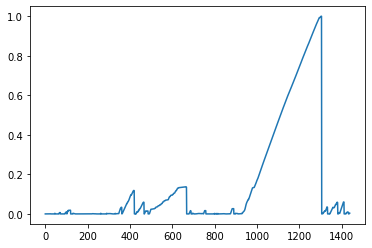

Vid done in 527.455297887 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/02


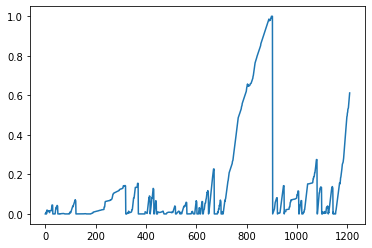

Vid done in 470.40427073699993 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/03


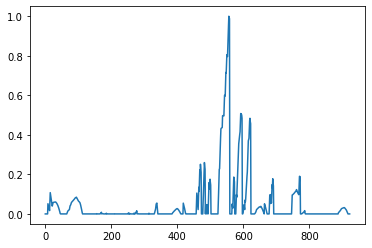

Vid done in 331.004158704 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/04


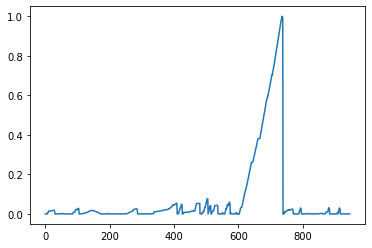

Vid done in 368.17791588 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/05


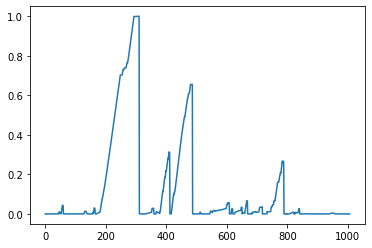

Vid done in 366.6110976660002 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/06


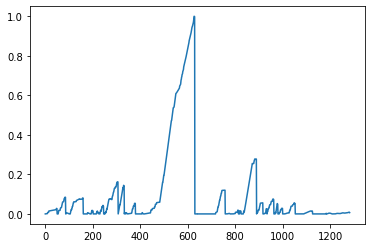

Vid done in 465.93407445 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/07


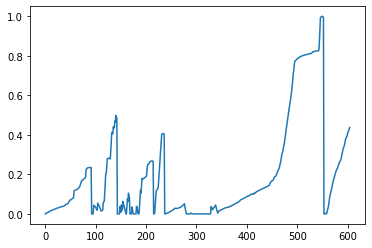

Vid done in 278.2477375520002 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/08


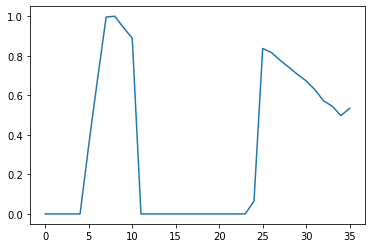

Vid done in 10.953846262000297 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/09


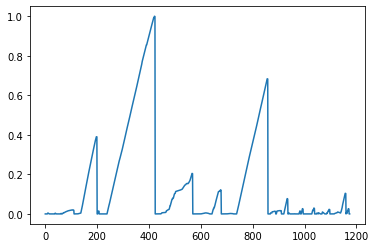

Vid done in 413.18904764599984 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/10


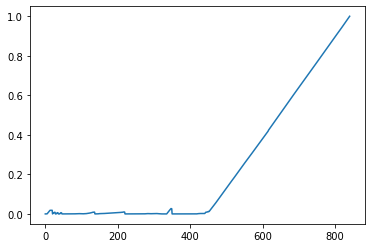

Vid done in 326.18917354999985 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/11


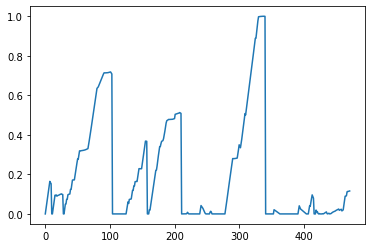

Vid done in 187.69163157599996 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/12


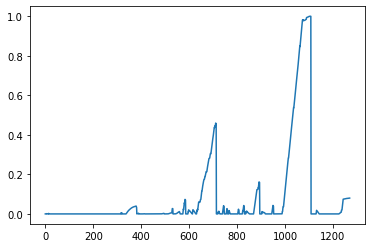

Vid done in 358.3837249920007 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/13


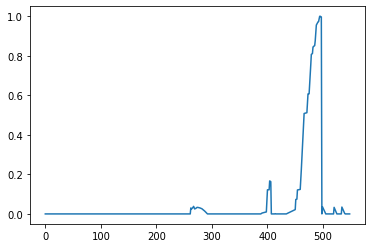

Vid done in 119.40600192200054 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/14


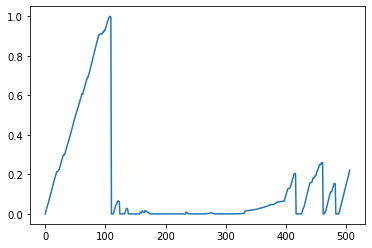

Vid done in 216.76788824899995 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/15


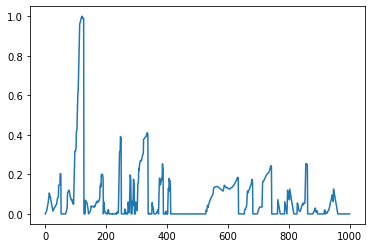

Vid done in 460.85358200599967 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/16


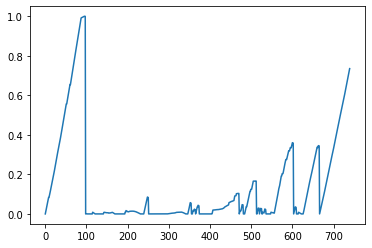

Vid done in 347.821509763 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/17


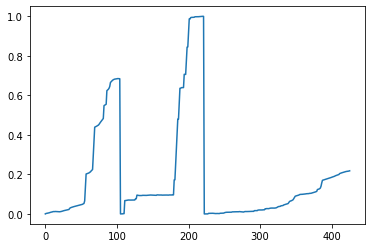

Vid done in 215.22095364899997 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/18


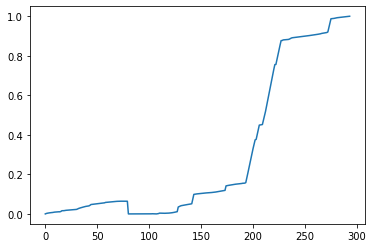

Vid done in 144.07853294199958 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/19


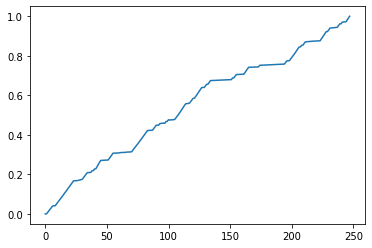

Vid done in 153.75407809300032 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/20


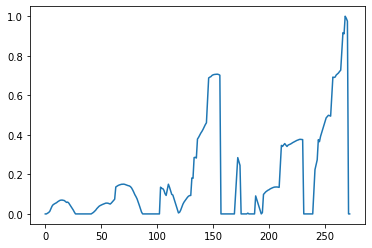

Vid done in 117.96182417899945 seconds
/home/guest/Documents/SafeCam/Dataset/Avenue Dataset/testing/frames/21


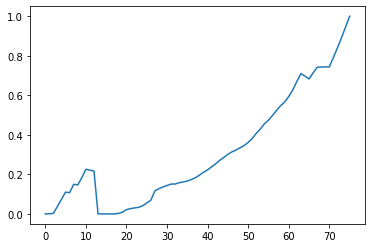

Vid done in 34.176988023000376 seconds
Ped2 dataset


FileNotFoundError: [Errno 2] No such file or directory: '/home/guest/Documents/SafeCam/Dataset/ped2/testing/frames'

In [15]:
#TESTING THE DATASET
parent_directory=os.path.dirname(os.getcwd())
direc=os.path.join(parent_directory,'Dataset')

AV2=list()    
print("avenue dataset")
#using the AVENUE TESTING dataset
curr_direc=os.path.join(direc,'Avenue Dataset','testing','frames')
for subdirec in np.sort(os.listdir(curr_direc)):
    video_frames=os.path.join(curr_direc,subdirec)
    print(video_frames)
    start=timer()
    frames_process(video_frames,AV2)
    end=timer()
    print("Vid done in",end-start,"seconds")
'''    
print("shangai dataset")
#using the SHANGAI TESTING dataset
curr_direc=os.path.join(direc,'ShangaiTech_testing','testing','frames')
for subdirec in np.sort(os.listdir(curr_direc)):
    video_frames=os.path.join(curr_direc,subdirec)
    start=timer()
    frames_process(video_frames,AV2)
    end=timer()
    print("Vid done in",end-start,"seconds")'''

In [16]:
from sklearn import metrics
sc = [item for sublist in AV2 for item in sublist]
labels = np.load('avenuelabels.npy',mmap_mode=None, allow_pickle=True, fix_imports=True)
labels=np.concatenate(labels).ravel().tolist()
print(len(labels))
print(len(sc))
fpr2, tpr2, thresholds = metrics.roc_curve(labels,sc,pos_label=1)
fpr2 = np.sort(np.append(fpr2,(0.45))) # We extrapolate a point so as to complete the ROC curve
tpr2 = np.sort(np.append(tpr2,(1)))

print('ODIT AUC:', metrics.auc(fpr2, tpr2))

15324
15324
ODIT AUC: 0.7135480635602672
